In [1]:
import os.path
import glob
from PIL import Image  
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt

# 测试输入数据集：flower_photos
INPUT_DATA = './dataset/orl_faces_png'
OUTPUT_FILE = './dataset/orl_faces.npy'
# 测试数据和验证数据比例
VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

In [2]:
# 定义函数转化变量类型。
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
#生成字符串的属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
#获取in_dir下的所有子文件夹
def get_sub_dir(in_dir):
    dirs = []
    if not os.path.exists(in_dir):  
        print(in_dir, 'is not existed.')  
        return -1
    for sub_dir in glob.glob(in_dir+'/*'):  
        #sub_dir:各个子文件夹
        dirs.append(sub_dir)
    return dirs
        
#获取in_dir下的所有jpg文件
def get_file(in_dir):
    files = []
    if not os.path.exists(in_dir):  
        print(in_dir, 'is not existed.')  
        return -1
    for file in glob.glob(in_dir+'/*.'+'png'):  
        #sub_dir:各个子文件夹
        files.append(file)
    return files
    
def one_hot(label, num):
    onehot = [0]*num
    onehot[label] = 1
    return np.array(onehot)
    
def create_image_lists(sess, testing_percentage, validation_percentage):
    #初始化数据集
    training_images = []
    training_labels = []
    testing_images = []
    testing_labels = []
    validation_images = []
    validation_labels = []
    
    #处理各个文件夹下的子文件
    dirs = get_sub_dir(INPUT_DATA)
    i = 0
    for sub_dir in dirs:
        print(i,'.processing:',sub_dir)
        i = i+1
        #标签名即为子文件夹sub_dir的名字-1,范围0~39
        _, label= os.path.split(sub_dir)
        label = int(label[1:])-1
        label_one_hot = one_hot(label, 40)
        #files：sub_dir下的文件列表
        files = get_file(sub_dir)
        for file in files:
            image_raw_data = gfile.FastGFile(file, 'rb').read()
            image = tf.image.decode_png(image_raw_data)
            ##这里unit8转为float32格式，暂时不做处理
#             if image.dtype != tf.float32:
#                 image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            #image_value:numpy.ndarry类型数据
            image = tf.image.resize_image_with_crop_or_pad(image, 112, 112)
            image_value = sess.run(image)
            chance = np.random.randint(100)
            if chance < validation_percentage:
                validation_images.append(image_value)
                validation_labels.append(label_one_hot)
            elif chance < (testing_percentage + validation_percentage):
                testing_images.append(image_value)
                testing_labels.append(label_one_hot)
            else:
                training_images.append(image_value)
                training_labels.append(label_one_hot)
    # 将训练数据随机打乱以获得更好的训练效果。
    state = np.random.get_state()
    np.random.shuffle(training_images)
    np.random.set_state(state)
    np.random.shuffle(training_labels)
    print('train_label[0]:',training_labels[0])
    plt.imshow(training_images[0].reshape(112, 112), cmap=plt.get_cmap('gray'))
    
    return np.asarray([training_images, training_labels,
                       validation_images, validation_labels,
                       testing_images, testing_labels])

processing ./dataset/orl_faces_png/s40
processing ./dataset/orl_faces_png/s39
processing ./dataset/orl_faces_png/s23
processing ./dataset/orl_faces_png/s17
processing ./dataset/orl_faces_png/s22
processing ./dataset/orl_faces_png/s14
processing ./dataset/orl_faces_png/s19
processing ./dataset/orl_faces_png/s15
processing ./dataset/orl_faces_png/s16
processing ./dataset/orl_faces_png/s28
processing ./dataset/orl_faces_png/s4
processing ./dataset/orl_faces_png/s1
processing ./dataset/orl_faces_png/s9
processing ./dataset/orl_faces_png/s30
processing ./dataset/orl_faces_png/s24
processing ./dataset/orl_faces_png/s25
processing ./dataset/orl_faces_png/s27
processing ./dataset/orl_faces_png/s34
processing ./dataset/orl_faces_png/s18
processing ./dataset/orl_faces_png/s5
processing ./dataset/orl_faces_png/s26
processing ./dataset/orl_faces_png/s6
processing ./dataset/orl_faces_png/s21
processing ./dataset/orl_faces_png/s2
processing ./dataset/orl_faces_png/s29
processing ./dataset/orl_faces_

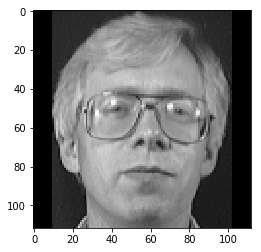

In [3]:
with tf.Session() as sess:
    photo_data = create_image_lists(sess, VALIDATION_PERCENTAGE, TEST_PERCENTAGE)
    np.save(OUTPUT_FILE, photo_data)
#     li = one_hot(4,5)
#     print(li,type(li))

In [4]:
# [training_images, training_labels,validation_images, validation_labels,testing_images, testing_labels]
for i in range(6):
#     print(list.count(photo_data[i]))
    print(np.asarray(photo_data[i]).shape)

(321, 112, 112, 1)
(321, 40)
(36, 112, 112, 1)
(36, 40)
(43, 112, 112, 1)
(43, 40)
